## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import time
import pylab as pl
import gmsh
from IPython import display
from matplotlib.path import Path
from scipy.sparse import csr_matrix,coo_array
from collections import Counter
%matplotlib inline
import scipy
import time
from multiprocessing import Manager,Pool
from worker1 import matrix_helper
from worker2 import picard_helper
from scipy.sparse.linalg import spsolve
import gc

## Utility functions

In [2]:
def createMesh(geo_file,meshFactorForEntireSurface,meshFactorForAdaptiveSurface=None,xSource=None,ySource=None,isMeshRectangle=False):
    '''Create Mesh File'''
    gmsh.initialize()
    gmsh.open(geo_file)
    if isMeshRectangle:
        gmsh.model.mesh.MeshSizeExtendFromBoundary = 0;
        gmsh.model.mesh.MeshSizeFromPoints = 0;
        gmsh.model.mesh.MeshSizeFromCurvature = 0;
        lenghtofAdaptiveSurface = 6 #mm
        gmsh.model.mesh.field.add("Box", 1)
        gmsh.model.mesh.field.setNumber(1, "VOut", meshFactorForEntireSurface)
        gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
        gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
        gmsh.model.mesh.field.setNumber(1, "VIn", meshFactorForAdaptiveSurface)     
        gmsh.model.mesh.field.setNumber(1, "XMax", min(xSource + lenghtofAdaptiveSurface,100)) 
        gmsh.model.mesh.field.setNumber(1, "XMin", max(xSource - lenghtofAdaptiveSurface,0)) 
        gmsh.model.mesh.field.setNumber(1, "YMax", min(ySource + lenghtofAdaptiveSurface,50)) 
        gmsh.model.mesh.field.setNumber(1, "YMin", max(ySource - lenghtofAdaptiveSurface,0))  
        # Apply the combined field as a background mesh
        gmsh.model.mesh.field.setAsBackgroundMesh(1)
    else:
        gmsh.option.setNumber("Mesh.MeshSizeFactor", meshFactorForEntireSurface)
    gmsh.model.mesh.generate(2)
    mesh_filename = 'Mesh.msh'
    gmsh.write(mesh_filename)
    gmsh.finalize()
    return read_mesh(mesh_filename)

def read_mesh(filepath):
    '''
    Takes in an msh file and should return nodal coordinates and element connectivity in each physical group along with the boundary nodes 
    '''
    gmsh.initialize()
    gmsh.open(filepath)
    print(f"Reading {filepath}")
    print(f"Number of nodes in the mesh: {int(gmsh.option.getNumber('Mesh.NbNodes'))}")
    print(f"Number of triangles in the mesh: {int(gmsh.option.getNumber('Mesh.NbTriangles'))}\n")

    #Get all nodes
    dim = -1
    tag = -1
    nodeTags, nodecoords, _ = gmsh.model.mesh.getNodes(dim,tag)
    nodecoords = nodecoords.reshape(-1,3) #tags start from 1

    #Get all triangles
    eleType = 2
    tag = -1
    elements_t,ele_con = gmsh.model.mesh.getElementsByType(eleType,-1)
    ele_con = ele_con.reshape(-1,3)  #tags start from 1

    gmsh.finalize()
    return [nodecoords,ele_con] 

In [3]:
''' Functions relating to source term and the properties of Titanium alloy '''
def Q(point,centre,ro):
    x = point[0,0] - centre[0,0]
    y = point[0,1] - centre[0,1]
    Qo = 5 ## amplitude in W/mm^2 
    return Qo*np.exp(-(x**2+y**2)/ro**2)  ## W/m^3

def rho_Ti(T, phase = 'alpha'):
    if phase == 'alpha':
        return -5.13e-5*(T**2)-0.01935*T+4451
    elif phase == 'beta':
        return -2.762e-6*(T**2)-0.1663*T+4468
    elif phase == 'liquid':
        return -0.565*T+5093
    else:
        return T

def cp_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.25*T+483
    elif phase == 'beta':
        return 0.14*T+530
    elif phase == 'liquid':
        return 930
    else:
        return T

def k_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.012*T+3.3
    elif phase == 'beta':
        return 0.016*T-3
    elif phase == 'liquid':
        return 0.0175*T-4.5
    else:
        return T

def props_chooser(T, T_rep, process = 'heating'):
    if (T_rep<1268 and process == 'heating') or (T_rep<=1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'alpha'),cp_Ti(T,phase = 'alpha'),k_Ti(T,phase = 'alpha')
    elif (T_rep<1928 and process == 'heating') or (T_rep>1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'beta'),cp_Ti(T,phase = 'beta'),k_Ti(T,phase = 'beta')
    elif (T_rep>=1928 and process == 'heating') or (T_rep>=1878 and process == 'cooling'):
        return rho_Ti(T,phase = 'liquid'),cp_Ti(T,phase = 'liquid'),k_Ti(T,phase = 'liquid')
    else:
        return -1
  

In [4]:
'''Parallel processing utility functions'''
def flatten(xss):
    return [x for xs in xss for x in xs] 

## Validation of quasi-static solver code

In [5]:
class FEM:
    def __init__(self,nodecoords,elecon,centre):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
        self.nodecoords = nodecoords
        self.elecon = elecon
        self.centre = centre
    
    def fit_ele(self,theta_prev_time = None,theta_prev_pic = None,mode = "linear",verbose = False):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''

        nodes = self.nodecoords
        ele = self.elecon
        source = self.centre

        #getting the boundary nodes
        
        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]

        #Data for FEA
        gp = 3
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K_row,K_col,K_data = [],[],[]
        K_D_row,K_D_col,K_D_data = [],[],[]
        G_row,G_col,G_data = [],[],[]
        M_row,M_col,M_data = [],[],[]
        M_D_row,M_D_col,M_D_data = [],[],[]

        #Parallel processing for matrix computations
        items = [(nodes,elei,source,theta_prev_time,theta_prev_pic,mode) for elei in ele]
        st = time.time()
        with Pool() as pool:
            results = pool.map(matrix_helper, items)
        if verbose == True:
            print(f"Time for pooling to end {time.time()-st}")

        #Accumulating data collected over multiprocessing
        st = time.time()
        K_row, K_col, K_data, K_D_row, K_D_col, K_D_data ,G_row, G_col, G_data, M_row, M_col, M_data, M_D_row, M_D_col, M_D_data, F_row,F_data, BT_row, BT_data,areas = list(zip(*results))
        mega = [K_row, K_col, K_data, K_D_row, K_D_col, K_D_data ,G_row, G_col, G_data, M_row, M_col, M_data, M_D_row, M_D_col, M_D_data, F_row,F_data, BT_row, BT_data]
        K_row, K_col, K_data, K_D_row, K_D_col, K_D_data ,G_row, G_col, G_data, M_row, M_col, M_data, M_D_row, M_D_col, M_D_data, F_row,F_data, BT_row, BT_data = [flatten(mini) for mini in mega]
        if verbose == True:
            print(f"Time for accumulation of data to end {time.time()-st}")

        self.h = np.sqrt(np.mean(areas)) 
        if verbose == True:
            print(f"Mesh size is {self.h} mm")
            print(f"Spot radius is 2 mm")

        #Preparing the matrices for calculations
        st = time.time()
        self.F = csr_matrix((F_data,(F_row,[0]*len(F_row))),shape = ((nop,1))).toarray()
        self.boundary_term = csr_matrix((BT_data,(BT_row,[0]*len(BT_row))),shape = ((nop,1))).toarray()
        
        self.K_sparse = csr_matrix((K_data,(K_row,K_col)),shape=(nop,nop))
        self.K_D_sparse = csr_matrix((K_D_data,(K_D_row,K_D_col)),shape=(nop,nop))
        self.G_sparse = csr_matrix((G_data,(G_row,G_col)),shape=(nop,nop))
        self.M_sparse = csr_matrix((M_data,(M_row,M_col)),shape=(nop,nop))
        self.M_D_sparse = csr_matrix((M_D_data,(M_D_row,M_D_col)),shape=(nop,nop))
        if verbose == True:
            print(f"Time for matrices creation {time.time()-st}")

        # #Converting sparse to dense matrix for submatrix extractions
        # st = time.time()
        # K = K_sparse.toarray()
        # G = G_sparse.toarray()
        # M = M_sparse.toarray()

        # if mode == "no_source":
        #     F = np.zeros((nop,1))
        #     G = np.zeros((nop,nop))
        # if verbose == True:
        #     print(f"Time for sparse to dense conversion {time.time()-st}")

        # #Setting up the right hand side by subtracting the dirichlet terms
        # T_l = 20
        # non_ln = np.setdiff1d(np.arange(K.shape[0]),ln)
        # rhs = F+boundary_term-T_l*np.sum((K[np.ix_(np.arange(K.shape[0]),ln)]\
        #                                   +G[np.ix_(np.arange(K.shape[0]),ln)]),axis = 1).reshape(-1,1)

        # #Sub matrix extractions
        # K_sub = K[np.ix_(non_ln,non_ln)]
        # G_sub = G[np.ix_(non_ln,non_ln)]
        # rhs_sub = rhs[np.ix_(non_ln,[0])]

        # #Back to sparse matrix for efficient inverse computation
        # K_sparse = coo_array(K_sub)
        # G_sparse = coo_array(G_sub)
        # rhs_sparse = coo_array(rhs_sub)
        
        # st = time.time()
        # theta_sub = scipy.sparse.linalg.spsolve(K_sparse+G_sparse,rhs_sparse)
        # if verbose == True:
        #     print(f"Time for inversion {time.time()-st}")

        # #Final solution with the dirichlet imposed
        # theta = np.zeros((K.shape[0],1))+T_l
        # theta[non_ln,:] = theta_sub.reshape(-1,1)
        
        # return [h,K,G,F,boundary_term,theta]
        return self.K_sparse,self.K_D_sparse,self.G_sparse,self.M_sparse,self.M_D_sparse,self.F,self.boundary_term
    def solver(self,theta_prev_time = None,dt = 1e-2,mode = "linear",verbose = False):
        tol = 1e-5
        delta_t = np.zeros((self.nodecoords.shape[0],1))
        # T = 20 + np.zeros((self.nodecoords.shape[0],1))
        theta_prev_pic = theta_prev_time.copy()
        dirichiletBoundary = np.where(self.nodecoords[:,0] == 0)[0]
        n = self.nodecoords.shape[0]
        nodes = np.arange(n)
        interiorNodes = np.delete(nodes,dirichiletBoundary)
        _,_,_,M_T_minus_1,_,_,_ = self.fit_ele(theta_prev_time,theta_prev_pic,mode,verbose)
        for i in range(20):  
            print(f"Newton Raphson Iteration {i+1}")  
            K,K_D,G,M,M_D,F,Boundary_term = self.fit_ele(theta_prev_time,theta_prev_pic,mode,verbose)
            R = ((M@theta_prev_pic - M_T_minus_1@theta_prev_time)/dt + K@theta_prev_pic - F - Boundary_term)[interiorNodes]
            J = (K_D + M_D/dt)[np.ix_(interiorNodes, interiorNodes)]
            delta_t[interiorNodes] = spsolve(J,-R).reshape(-1,1)  
            print(f"Norm of delta_t is {np.linalg.norm(delta_t)}")
            theta_prev_pic[interiorNodes] = theta_prev_pic[interiorNodes] + delta_t[interiorNodes]
            if np.linalg.norm(delta_t) < tol:
                break
        return theta_prev_pic

Reading Rectangular1.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Newton Raphson Iteration 1
Norm of delta_t is 1285.2739681634432
Newton Raphson Iteration 2
Norm of delta_t is 347.3317612651052
Newton Raphson Iteration 3
Norm of delta_t is 71.99190097873617
Newton Raphson Iteration 4
Norm of delta_t is 15.681545907602827
Newton Raphson Iteration 5
Norm of delta_t is 3.35321544662587
Newton Raphson Iteration 6
Norm of delta_t is 0.7178961606163199
Newton Raphson Iteration 7
Norm of delta_t is 0.1535023814536389
Newton Raphson Iteration 8
Norm of delta_t is 0.03281964916652403
Newton Raphson Iteration 9
Norm of delta_t is 0.007016286426883531
Newton Raphson Iteration 10
Norm of delta_t is 0.0014999335020402808
Newton Raphson Iteration 11
Norm of delta_t is 0.00032065065681291977
Newton Raphson Iteration 12
Norm of delta_t is 6.854739955296685e-05
Newton Raphson Iteration 13
Norm of delta_t is 1.4653767798167772e-05
Newton Raphson Iteration 14
Norm of delt

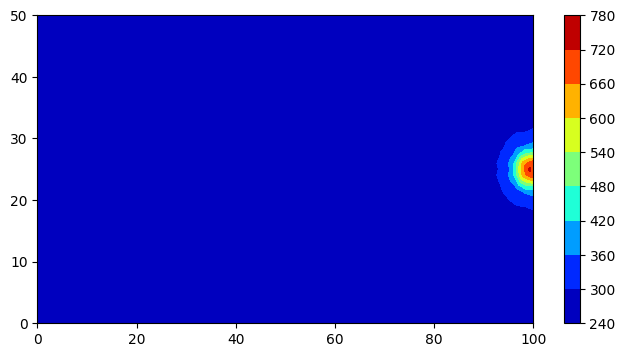

Newton Raphson Iteration 1
Norm of delta_t is 981.5277511698591
Newton Raphson Iteration 2
Norm of delta_t is 292.4633713975339
Newton Raphson Iteration 3
Norm of delta_t is 76.47147585668226
Newton Raphson Iteration 4
Norm of delta_t is 20.07084657989193
Newton Raphson Iteration 5
Norm of delta_t is 5.136261621328502
Newton Raphson Iteration 6
Norm of delta_t is 1.3092718994358827
Newton Raphson Iteration 7
Norm of delta_t is 0.3326638266235698
Newton Raphson Iteration 8
Norm of delta_t is 0.08445761511441383
Newton Raphson Iteration 9
Norm of delta_t is 0.02143375035739903
Newton Raphson Iteration 10
Norm of delta_t is 0.005438834920097741
Newton Raphson Iteration 11
Norm of delta_t is 0.0013800401582305278
Newton Raphson Iteration 12
Norm of delta_t is 0.00035016308790133255
Newton Raphson Iteration 13
Norm of delta_t is 8.884769418971202e-05
Newton Raphson Iteration 14
Norm of delta_t is 2.254347978459411e-05
Newton Raphson Iteration 15
Norm of delta_t is 5.719991280366425e-06


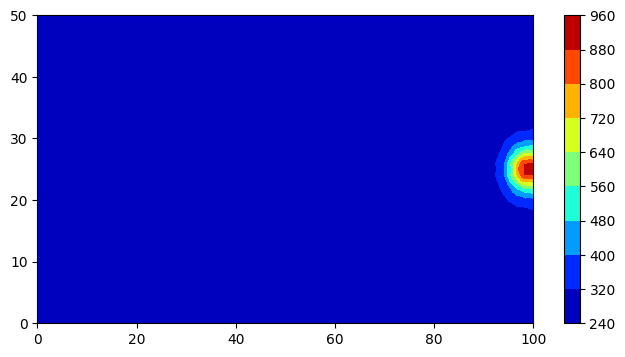

Newton Raphson Iteration 1
Norm of delta_t is 821.8527769340042
Newton Raphson Iteration 2
Norm of delta_t is 238.2738044312684
Newton Raphson Iteration 3
Norm of delta_t is 66.55808963809243
Newton Raphson Iteration 4
Norm of delta_t is 18.67966508670726
Newton Raphson Iteration 5
Norm of delta_t is 5.124812179680602
Newton Raphson Iteration 6
Norm of delta_t is 1.3969912704984622
Newton Raphson Iteration 7
Norm of delta_t is 0.3791535785797565
Newton Raphson Iteration 8
Norm of delta_t is 0.1027510159893356
Newton Raphson Iteration 9
Norm of delta_t is 0.027825162647881877
Newton Raphson Iteration 10
Norm of delta_t is 0.007532988080457997
Newton Raphson Iteration 11
Norm of delta_t is 0.0020391168976466945
Newton Raphson Iteration 12
Norm of delta_t is 0.0005519435493110407
Newton Raphson Iteration 13
Norm of delta_t is 0.00014939547336926973
Newton Raphson Iteration 14
Norm of delta_t is 4.043673618005183e-05
Newton Raphson Iteration 15
Norm of delta_t is 1.0944929450342848e-05
New

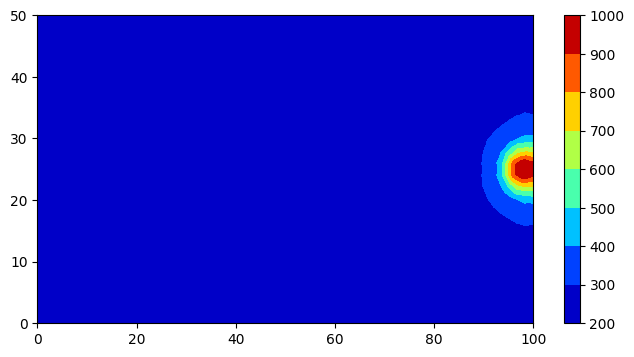

Newton Raphson Iteration 1
Norm of delta_t is 750.6707589745243
Newton Raphson Iteration 2
Norm of delta_t is 203.90200963231436
Newton Raphson Iteration 3
Norm of delta_t is 56.779144656460886
Newton Raphson Iteration 4
Norm of delta_t is 16.22771333718451
Newton Raphson Iteration 5
Norm of delta_t is 4.575756561657857
Newton Raphson Iteration 6
Norm of delta_t is 1.2838171345205776
Newton Raphson Iteration 7
Norm of delta_t is 0.3587578166736112
Newton Raphson Iteration 8
Norm of delta_t is 0.10008506298398678
Newton Raphson Iteration 9
Norm of delta_t is 0.02789604944562923
Newton Raphson Iteration 10
Norm of delta_t is 0.007772051815855362
Newton Raphson Iteration 11
Norm of delta_t is 0.002164896315250352
Newton Raphson Iteration 12
Norm of delta_t is 0.0006029673831434632
Newton Raphson Iteration 13
Norm of delta_t is 0.0001679297874729204
Newton Raphson Iteration 14
Norm of delta_t is 4.6768138182320644e-05
Newton Raphson Iteration 15
Norm of delta_t is 1.3024661029112125e-05
Ne

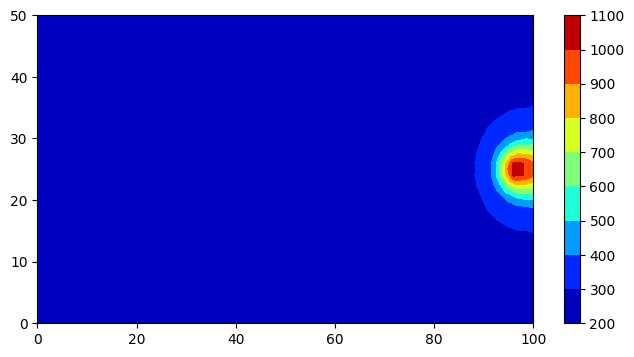

Newton Raphson Iteration 1
Norm of delta_t is 717.8355971160692
Newton Raphson Iteration 2
Norm of delta_t is 186.57418123576892
Newton Raphson Iteration 3
Norm of delta_t is 50.70756934998013
Newton Raphson Iteration 4
Norm of delta_t is 14.406734083470347
Newton Raphson Iteration 5
Norm of delta_t is 4.084723017761578
Newton Raphson Iteration 6
Norm of delta_t is 1.1579671924507207
Newton Raphson Iteration 7
Norm of delta_t is 0.3277061147116872
Newton Raphson Iteration 8
Norm of delta_t is 0.09267099925379114
Newton Raphson Iteration 9
Norm of delta_t is 0.026192563806342745
Newton Raphson Iteration 10
Norm of delta_t is 0.0074010878574517994
Newton Raphson Iteration 11
Norm of delta_t is 0.0020909526683060304
Newton Raphson Iteration 12
Norm of delta_t is 0.0005906825548006689
Newton Raphson Iteration 13
Norm of delta_t is 0.00016685582839477223
Newton Raphson Iteration 14
Norm of delta_t is 4.713194349546791e-05
Newton Raphson Iteration 15
Norm of delta_t is 1.3313168503501856e-05

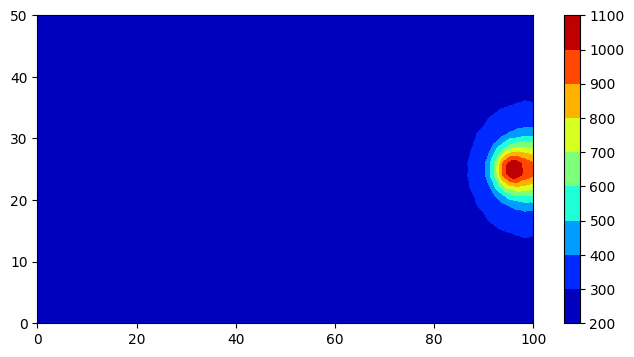

Newton Raphson Iteration 1
Norm of delta_t is 698.1545802188085
Newton Raphson Iteration 2
Norm of delta_t is 176.38196439133668
Newton Raphson Iteration 3
Norm of delta_t is 47.18229573141755
Newton Raphson Iteration 4
Norm of delta_t is 13.284006043899732
Newton Raphson Iteration 5
Norm of delta_t is 3.754294116641214
Newton Raphson Iteration 6
Norm of delta_t is 1.0652629449236592
Newton Raphson Iteration 7
Norm of delta_t is 0.30260138031888384
Newton Raphson Iteration 8
Norm of delta_t is 0.08603979746321071
Newton Raphson Iteration 9
Norm of delta_t is 0.024476023795752044
Newton Raphson Iteration 10
Norm of delta_t is 0.006964900413192186
Newton Raphson Iteration 11
Norm of delta_t is 0.0019822664431238548
Newton Raphson Iteration 12
Norm of delta_t is 0.0005642240146390182
Newton Raphson Iteration 13
Norm of delta_t is 0.00016060733993449288
Newton Raphson Iteration 14
Norm of delta_t is 4.571866720621171e-05
Newton Raphson Iteration 15
Norm of delta_t is 1.301458542546187e-05


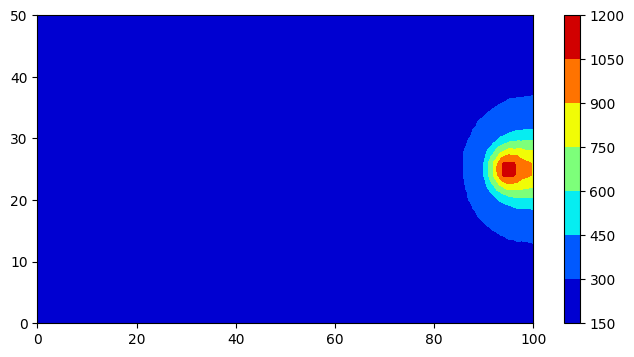

Newton Raphson Iteration 1
Norm of delta_t is 688.4359859973425
Newton Raphson Iteration 2
Norm of delta_t is 170.53346348059245
Newton Raphson Iteration 3
Norm of delta_t is 44.99653098124866
Newton Raphson Iteration 4
Norm of delta_t is 12.57295817726137
Newton Raphson Iteration 5
Norm of delta_t is 3.5392662788252047
Newton Raphson Iteration 6
Norm of delta_t is 1.0024897000949464
Newton Raphson Iteration 7
Norm of delta_t is 0.28479119357090604
Newton Raphson Iteration 8
Norm of delta_t is 0.08109747186917746
Newton Raphson Iteration 9
Norm of delta_t is 0.02312897842301715
Newton Raphson Iteration 10
Norm of delta_t is 0.0066031749021175845
Newton Raphson Iteration 11
Norm of delta_t is 0.001886398619523042
Newton Raphson Iteration 12
Norm of delta_t is 0.000539133464489006
Newton Raphson Iteration 13
Norm of delta_t is 0.0001541259327137849
Newton Raphson Iteration 14
Norm of delta_t is 4.406876008384868e-05
Newton Raphson Iteration 15
Norm of delta_t is 1.2601890200189305e-05
Ne

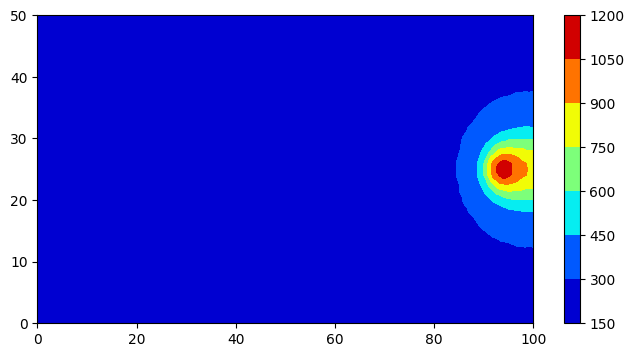

Newton Raphson Iteration 1
Norm of delta_t is 685.2445016719724
Newton Raphson Iteration 2
Norm of delta_t is 167.46929408551566
Newton Raphson Iteration 3
Norm of delta_t is 43.70787641427921
Newton Raphson Iteration 4
Norm of delta_t is 12.138339513805242
Newton Raphson Iteration 5
Norm of delta_t is 3.405233320099322
Newton Raphson Iteration 6
Norm of delta_t is 0.9625355591219302
Newton Raphson Iteration 7
Norm of delta_t is 0.27316832250972406
Newton Raphson Iteration 8
Norm of delta_t is 0.07778322214375344
Newton Raphson Iteration 9
Norm of delta_t is 0.022200323182776288
Newton Raphson Iteration 10
Norm of delta_t is 0.00634685915267093
Newton Raphson Iteration 11
Norm of delta_t is 0.0018165820734314011
Newton Raphson Iteration 12
Norm of delta_t is 0.0005203431766540725
Newton Raphson Iteration 13
Norm of delta_t is 0.00014912652943036876
Newton Raphson Iteration 14
Norm of delta_t is 4.2754082015287456e-05
Newton Raphson Iteration 15
Norm of delta_t is 1.2260528152804433e-05

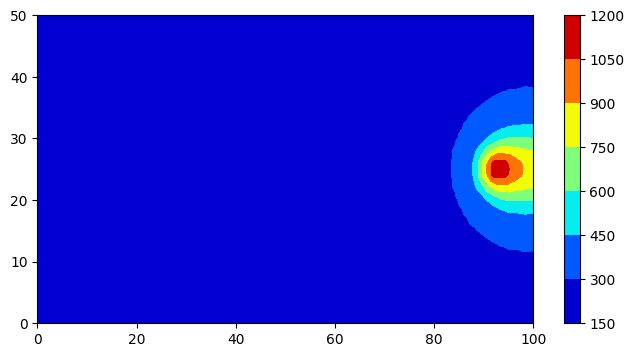

Newton Raphson Iteration 1
Norm of delta_t is 684.1251651816971
Newton Raphson Iteration 2
Norm of delta_t is 166.40676997651107
Newton Raphson Iteration 3
Norm of delta_t is 43.07321813544358
Newton Raphson Iteration 4
Norm of delta_t is 11.893912099102307
Newton Raphson Iteration 5
Norm of delta_t is 3.32698701252775
Newton Raphson Iteration 6
Norm of delta_t is 0.9390043172184283
Newton Raphson Iteration 7
Norm of delta_t is 0.2662952454738742
Newton Raphson Iteration 8
Norm of delta_t is 0.07581367519449864
Newton Raphson Iteration 9
Norm of delta_t is 0.02164539437922778
Newton Raphson Iteration 10
Norm of delta_t is 0.00619297688405979
Newton Raphson Iteration 11
Norm of delta_t is 0.0017745577874394714
Newton Raphson Iteration 12
Norm of delta_t is 0.0005090370009959794
Newton Raphson Iteration 13
Norm of delta_t is 0.00014613060690389139
Newton Raphson Iteration 14
Norm of delta_t is 4.197300756388879e-05
Newton Raphson Iteration 15
Norm of delta_t is 1.2060602747385526e-05
New

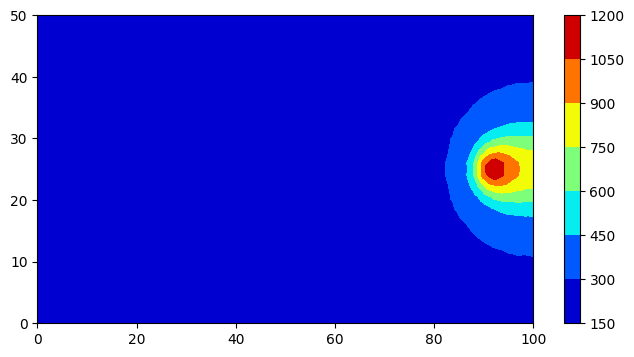

Newton Raphson Iteration 1
Norm of delta_t is 682.9572907602176
Newton Raphson Iteration 2
Norm of delta_t is 165.3727581796451
Newton Raphson Iteration 3
Norm of delta_t is 42.696155509086175
Newton Raphson Iteration 4
Norm of delta_t is 11.763285581994007
Newton Raphson Iteration 5
Norm of delta_t is 3.2859231799472277
Newton Raphson Iteration 6
Norm of delta_t is 0.9268038301522834
Newton Raphson Iteration 7
Norm of delta_t is 0.2627930823946898
Newton Raphson Iteration 8
Norm of delta_t is 0.07483203251893931
Newton Raphson Iteration 9
Norm of delta_t is 0.02137615075852067
Newton Raphson Iteration 10
Norm of delta_t is 0.006120792605006422
Newton Raphson Iteration 11
Norm of delta_t is 0.0017556955647153138
Newton Raphson Iteration 12
Norm of delta_t is 0.0005042562299485791
Newton Raphson Iteration 13
Norm of delta_t is 0.00014496499882183376
Newton Raphson Iteration 14
Norm of delta_t is 4.170379189589564e-05
Newton Raphson Iteration 15
Norm of delta_t is 1.2003540752958011e-05


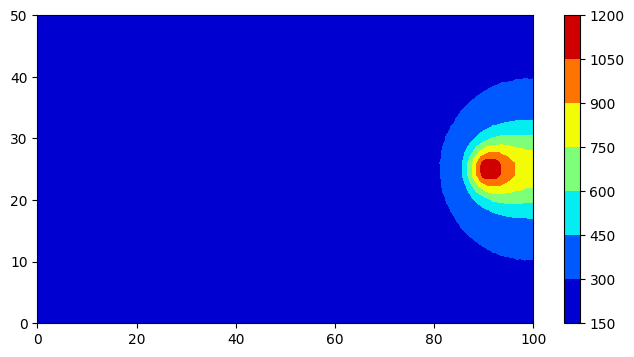

Newton Raphson Iteration 1
Norm of delta_t is 683.2838221346985
Newton Raphson Iteration 2
Norm of delta_t is 164.96539536060726
Newton Raphson Iteration 3
Norm of delta_t is 42.44159070737926
Newton Raphson Iteration 4
Norm of delta_t is 11.668855711411242
Newton Raphson Iteration 5
Norm of delta_t is 3.2579842230759155
Newton Raphson Iteration 6
Norm of delta_t is 0.9191964320553716
Newton Raphson Iteration 7
Norm of delta_t is 0.260809540294419
Newton Raphson Iteration 8
Norm of delta_t is 0.0743310205904548
Newton Raphson Iteration 9
Norm of delta_t is 0.02125425222571274
Newton Raphson Iteration 10
Norm of delta_t is 0.00609273921971026
Newton Raphson Iteration 11
Norm of delta_t is 0.0017498271481048264
Newton Raphson Iteration 12
Norm of delta_t is 0.0005032540866660316
Newton Raphson Iteration 13
Norm of delta_t is 0.00014488840757583408
Newton Raphson Iteration 14
Norm of delta_t is 4.1746425099892465e-05
Newton Raphson Iteration 15
Norm of delta_t is 1.2035374421718283e-05
Ne

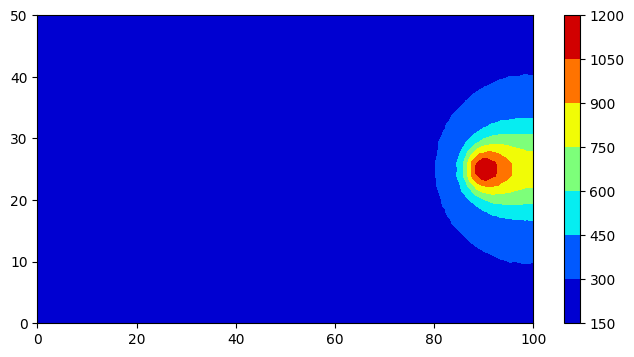

Newton Raphson Iteration 1
Norm of delta_t is 685.964380432047
Newton Raphson Iteration 2
Norm of delta_t is 164.85556533760166
Newton Raphson Iteration 3
Norm of delta_t is 42.29476030483869
Newton Raphson Iteration 4
Norm of delta_t is 11.610305814489006
Newton Raphson Iteration 5
Norm of delta_t is 3.239692684994559
Newton Raphson Iteration 6
Norm of delta_t is 0.9141436086613843
Newton Raphson Iteration 7
Norm of delta_t is 0.259529982408932
Newton Raphson Iteration 8
Norm of delta_t is 0.07403137949866184
Newton Raphson Iteration 9
Norm of delta_t is 0.021190931936901383
Newton Raphson Iteration 10
Norm of delta_t is 0.006081744508051585
Newton Raphson Iteration 11
Norm of delta_t is 0.0017488926162886125
Newton Raphson Iteration 12
Norm of delta_t is 0.0005036653411616129
Newton Raphson Iteration 13
Norm of delta_t is 0.00014521274919502406
Newton Raphson Iteration 14
Norm of delta_t is 4.190176551469142e-05
Newton Raphson Iteration 15
Norm of delta_t is 1.2098636972375798e-05
Ne

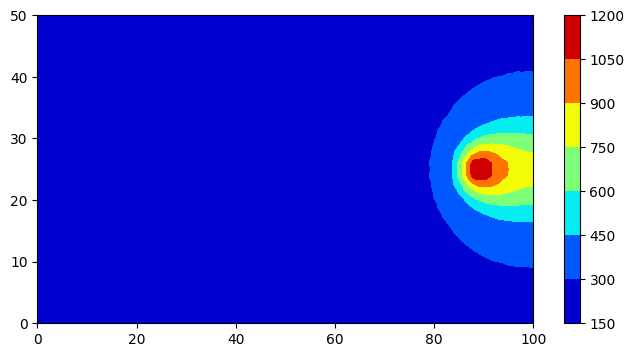

Newton Raphson Iteration 1
Norm of delta_t is 690.2058257533971
Newton Raphson Iteration 2
Norm of delta_t is 165.8815052345915
Newton Raphson Iteration 3
Norm of delta_t is 42.3701044245063
Newton Raphson Iteration 4
Norm of delta_t is 11.595406330029432
Newton Raphson Iteration 5
Norm of delta_t is 3.2313740383409755
Newton Raphson Iteration 6
Norm of delta_t is 0.9115851589858647
Newton Raphson Iteration 7
Norm of delta_t is 0.25889766950327586
Newton Raphson Iteration 8
Norm of delta_t is 0.07390302140679675
Newton Raphson Iteration 9
Norm of delta_t is 0.02117345829727429
Newton Raphson Iteration 10
Norm of delta_t is 0.006083077987792523
Newton Raphson Iteration 11
Norm of delta_t is 0.0017512679537154444
Newton Raphson Iteration 12
Norm of delta_t is 0.0005049594813358862
Newton Raphson Iteration 13
Norm of delta_t is 0.00014577016892443692
Newton Raphson Iteration 14
Norm of delta_t is 4.211779944940397e-05
Newton Raphson Iteration 15
Norm of delta_t is 1.2177435836103873e-05
N

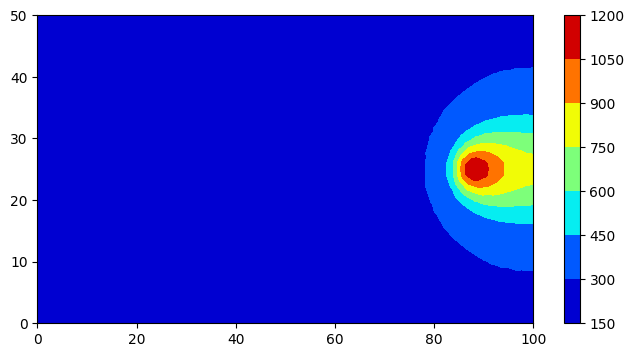

Newton Raphson Iteration 1
Norm of delta_t is 691.7196920966442
Newton Raphson Iteration 2
Norm of delta_t is 166.75476596522313
Newton Raphson Iteration 3


In [ ]:
filename = f"Rectangular1.msh"
nodecoords,ele_con = read_mesh(filename) #node tags start from 1
deltaT = 0.5
L = 10
v0 = 2
steps = int(L/deltaT)
Temperatures = 293*np.ones((steps+1,nodecoords.shape[0]))
for step in range(1,steps+1):
    soln1 = FEM(nodecoords,ele_con,np.array([[100-v0*step*deltaT,25]]))
    Temperatures[step,:]= soln1.solver(theta_prev_time = Temperatures[step-1,:].reshape(-1,1),dt = deltaT,mode = "phase_change",verbose = False).reshape(-1)
    plt.figure(figsize=(8,4))
    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],Temperatures[step,:],cmap = 'jet')
    plt.colorbar()
    plt.show()

In [33]:
filename = f"rectangle_vary_0.5_1.msh"
nodecoords,ele_con = read_mesh(filename) #node tags start from 1
soln1 = FEM(nodecoords,ele_con,np.array([[50,25]]))

Reading rectangle_vary_0.5_1.msh
Number of nodes in the mesh: 9806
Number of triangles in the mesh: 19286



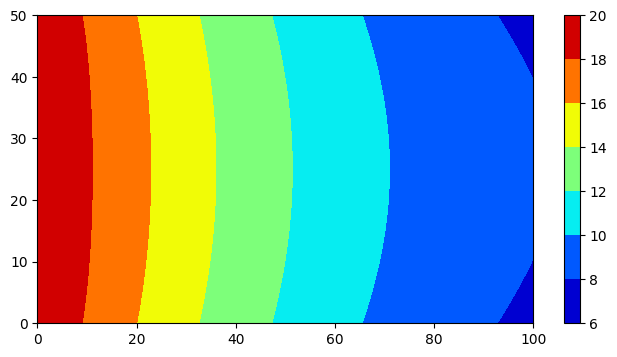

In [36]:
h,K,G,F,boundary,theta = soln1.fit_ele(mode = "no_source",verbose = False)
gc.collect()
plt.figure(figsize=(8,4))
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
plt.colorbar()
plt.show()

In [ ]:
print(f"The maximum temperature is {np.max(theta):.2f} C and the minimum temperature is {np.min(theta):.2f} C")

The maximum temperature is 630.49 $^o$C and the minimum temperature is 19.63 K


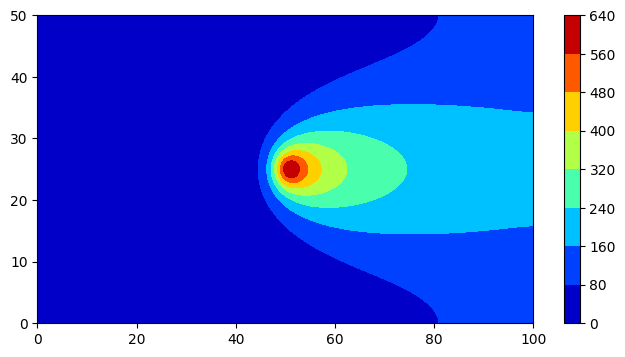

In [37]:
_,K,G,F,boundary,theta = soln1.fit_ele(mode = "linear",verbose = False)
# h,K,G,F,boundary_term,theta
gc.collect()
plt.figure(figsize=(8,4))
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
plt.colorbar()
plt.show()

In [10]:
print(f"The maximum temperature is {np.max(theta):.2f} K and the minimum temperature is {np.min(theta):.2f} K")

The maximum temperature is 630.49 K and the minimum temperature is 19.63 K


## Validation of picard iteration

In [11]:
def Q(point):
    x = point[0,0] #in mm
    return 15e-3*(x/100)*(1-x/100) ## W/mm^3

def k_T(T):
    # return np.ones_like(T)*110
    return (100+0.004*(T-50-273)**2)*1e-3  ##W/mmK

In [12]:
class Picard_valid:
    def __init__(self,nodecoords,elecon):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
        self.nodecoords = nodecoords
        self.elecon = elecon
                        
    def fit_ele(self,dt,theta_prev_time = None,theta_prev_pic = None,mode = "linear",scheme = "implicit",verbose = False):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''
        gp = 3

        qo = 0   # W/mm^2
        c = 465 #J/kg.K
        rho = 7e-6 #kg/mm^3

        nodes = self.nodecoords
        ele = self.elecon
        
        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]
        
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K_row,K_col,K_data = [],[],[]
        M_row,M_col,M_data = [],[],[]

        #Parallel processing for matrix computations
        items = [(nodes,elei,theta_prev_time,theta_prev_pic,mode,scheme) for elei in ele]
        st = time.time()
        with Pool(processes = 4) as pool:
            results = pool.map(picard_helper, items)
        if verbose == True:
            print(f"Time for pooling to end {time.time()-st}")

        #Accumulating data collected over multiprocessing
        st = time.time()
        K_row, K_col, K_data, M_row, M_col, M_data, F_row,F_data,areas = list(zip(*results))
        mega = [K_row, K_col, K_data, M_row, M_col, M_data, F_row,F_data]
        K_row, K_col, K_data, M_row, M_col, M_data, F_row,F_data = [flatten(mini) for mini in mega]
        if verbose == True:
            print(f"Time for accumulation of data to end {time.time()-st}")

        #Preparing the matrices for calculations
        st = time.time()
        F= coo_array((F_data,(F_row,[0]*len(F_row))),shape = ((nop,1))).toarray()
        
        K_sparse = coo_array((K_data,(K_row,K_col)),shape=(nop,nop))
        M_sparse = coo_array((M_data,(M_row,M_col)),shape=(nop,nop))
        if verbose == True:
            print(f"Time for matrices creation {time.time()-st}")

        #Converting sparse to dense matrix for submatrix extractions
        st = time.time()
        K = K_sparse.toarray()
        M = M_sparse.toarray()

        if verbose == True:
            print(f"Time for sparse to dense conversion {time.time()-st}")
        
        #setting up the right hand side
        T_b = 273+100
        non_bn = np.setdiff1d(np.arange(K.shape[0]),bn)
        rhs = (F+M@theta_prev_time/dt)\
               -T_b*np.sum(K[np.ix_(np.arange(K.shape[0]),bn)]+M[np.ix_(np.arange(K.shape[0]),bn)]/dt,axis = 1).reshape(-1,1)
        
        K_sub = K[np.ix_(non_bn,non_bn)]
        M_sub = M[np.ix_(non_bn,non_bn)]
        rhs_sub = rhs[np.ix_(non_bn,[0])]
        theta_sub = np.linalg.inv(K_sub+M_sub/dt)@(rhs_sub)

        theta = np.zeros((K.shape[0],1))+T_b
        theta[non_bn,:] = theta_sub.reshape(-1,1)
        
        return [M,K,F,theta]

In [13]:
def picard(soln,nodecoords,ele_con,theta_init):
    dt = 1
    times = np.arange(0,10,dt)
    theta_prev_time = theta_init
    
    for t in times:
        e = 1e5
        tolerance = 1e-4
        iter = 0
        theta_prev_pic = theta_prev_time
        while(e>tolerance):
            iter +=1
            M,K,F,theta_new = soln.fit_ele(dt,theta_prev_time = theta_prev_time,theta_prev_pic = theta_prev_pic,mode = "non_linear",scheme = "implicit")
            e = np.linalg.norm(theta_new - theta_prev_pic)
            theta_prev_pic = theta_new
            if t == round(t):
                print(f"Error at {iter} iteration at time {t} is {e:.2E}")
        theta_prev_time = theta_new
        
    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten()-273, cmap = 'jet')
    plt.title(f"Converged solution")
    plt.colorbar()
    plt.show()

    return theta_new
        

Reading Mesh.msh
Number of nodes in the mesh: 380
Number of triangles in the mesh: 690

Error at 1 iteration at time 0 is 2.34E+02
Error at 2 iteration at time 0 is 3.52E+00
Error at 3 iteration at time 0 is 3.69E-02
Error at 4 iteration at time 0 is 2.79E-04
Error at 5 iteration at time 0 is 1.79E-06
Error at 1 iteration at time 1 is 6.46E+01
Error at 2 iteration at time 1 is 4.82E-01
Error at 3 iteration at time 1 is 2.65E-03
Error at 4 iteration at time 1 is 1.24E-05
Error at 1 iteration at time 2 is 4.52E+01
Error at 2 iteration at time 2 is 2.56E-01
Error at 3 iteration at time 2 is 1.29E-03
Error at 4 iteration at time 2 is 1.17E-05
Error at 1 iteration at time 3 is 3.69E+01
Error at 2 iteration at time 3 is 1.62E-01
Error at 3 iteration at time 3 is 9.17E-04
Error at 4 iteration at time 3 is 8.05E-06
Error at 1 iteration at time 4 is 3.23E+01
Error at 2 iteration at time 4 is 1.15E-01
Error at 3 iteration at time 4 is 6.96E-04
Error at 4 iteration at time 4 is 5.51E-06
Error at 

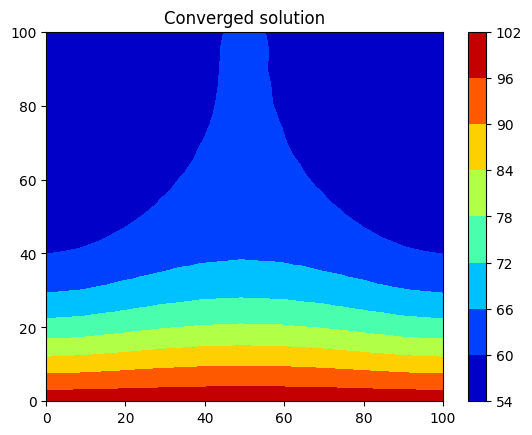

In [14]:
mesh_size_factor = 3
filename = f"square_{mesh_size_factor}.msh"
nodecoords,ele_con = createMesh(geo_file='squareDomain.geo',
                                meshFactorForEntireSurface=mesh_size_factor) 
soln3 = Picard_valid(nodecoords,ele_con)
T_b = 273+50
theta_init = np.zeros((nodecoords.shape[0],1))+T_b
theta_final = picard(soln3,nodecoords,ele_con,theta_init)

In [15]:
Ta = theta_final[np.where((nodecoords[:,0] == 0) * (nodecoords[:,1] == 100)) [0][0]]-273
Tb = theta_final[np.where((nodecoords[:,0] == 100) * (nodecoords[:,1] == 100)) [0][0]]-273
print(f"The temperature at node a is {Ta[0]:.2f}K and at node b is {Tb[0]:.2f}K")

The temperature at node a is 54.74K and at node b is 54.74K


## Mesh convergence

In [16]:
# Finding mesh size factor for the adaptive mesh part
mesh_size_factor = 3
areaOfPatchRegion = 12 * 12
area_overall = 100*50
meshFactorsForPatchSurface = np.arange(0.1,0.2,0.01)
hOfPathArea = []
h = []
for meshFactorForPatchSurface in meshFactorsForPatchSurface:
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                        meshFactorForEntireSurface=mesh_size_factor,
                                        meshFactorForAdaptiveSurface=meshFactorForPatchSurface,
                                        xSource=50,
                                        ySource=25,
                                        isMeshRectangle=True
                                    )
    nodesInPatchArea = np.where((np.max(nodecoords[ele_con-1][:,:,0],axis=1)<56)*(np.min(nodecoords[ele_con-1][:,:,0],axis=1)>44)*(np.max(nodecoords[ele_con-1][:,:,1],axis=1)<31)*(np.min(nodecoords[ele_con-1][:,:,1],axis=1)>19))[0]
    hOfPathArea.append((areaOfPatchRegion / len(nodesInPatchArea))**.5)
    h.append((area_overall / len(nodecoords))**.5)
    print(f"h_patch {hOfPathArea[-1]}")
    print(f"h_total {h[-1]}")

Reading Mesh.msh
Number of nodes in the mesh: 15111
Number of triangles in the mesh: 30118

h_patch 0.071156806696482
h_total 0.5752258564403582
Reading Mesh.msh
Number of nodes in the mesh: 12606
Number of triangles in the mesh: 25108

h_patch 0.07832771355170637
h_total 0.6297908559918702
Reading Mesh.msh
Number of nodes in the mesh: 10852
Number of triangles in the mesh: 21600

h_patch 0.08492715754489341
h_total 0.678781675661736
Reading Mesh.msh
Number of nodes in the mesh: 9275
Number of triangles in the mesh: 18446

h_patch 0.09250495460811899
h_total 0.7342230982143523
Reading Mesh.msh
Number of nodes in the mesh: 8088
Number of triangles in the mesh: 16072

h_patch 0.099871774825533
h_total 0.7862568296530488
Reading Mesh.msh
Number of nodes in the mesh: 7136
Number of triangles in the mesh: 14168

h_patch 0.10702347787777115
h_total 0.8370619127280313
Reading Mesh.msh
Number of nodes in the mesh: 6390
Number of triangles in the mesh: 12676

h_patch 0.11417702599266696
h_total

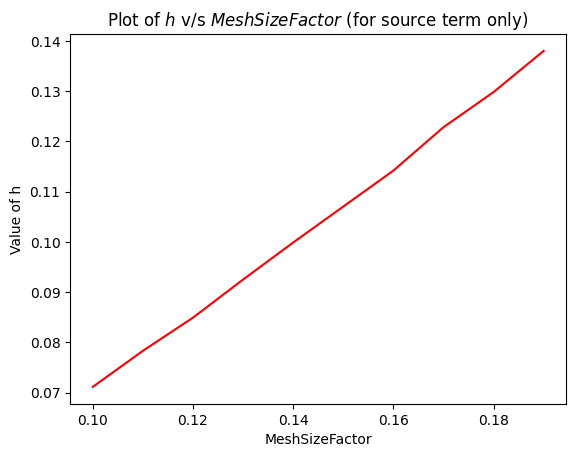

In [17]:
plt.plot(meshFactorsForPatchSurface,hOfPathArea,'r')
plt.xlabel('MeshSizeFactor')
plt.ylabel('Value of h')
plt.title('Plot of $h$ v/s $Mesh Size Factor$ (for source term only)')
plt.show()

In [18]:
print('Value of h for mesh size factor 0.15 is '+str(hOfPathArea[4]))

Value of h for mesh size factor 0.15 is 0.099871774825533


Using Mesh Size Factor for adaptive Surface as 0.14 (whose corresponding vale of h is 0.09250495460811899)

In [19]:
print(hOfPathArea)

[0.071156806696482, 0.07832771355170637, 0.08492715754489341, 0.09250495460811899, 0.099871774825533, 0.10702347787777115, 0.11417702599266696, 0.12280111196910334, 0.12979991081667525, 0.1379857364617018]


1
Reading Mesh.msh
Number of nodes in the mesh: 12958
Number of triangles in the mesh: 25614

5
Reading Mesh.msh
Number of nodes in the mesh: 5948
Number of triangles in the mesh: 11832

10
Reading Mesh.msh
Number of nodes in the mesh: 4753
Number of triangles in the mesh: 9470

15
Reading Mesh.msh
Number of nodes in the mesh: 3580
Number of triangles in the mesh: 7134

20
Reading Mesh.msh
Number of nodes in the mesh: 2229
Number of triangles in the mesh: 4436

25
Reading Mesh.msh
Number of nodes in the mesh: 2214
Number of triangles in the mesh: 4412

30
Reading Mesh.msh
Number of nodes in the mesh: 1177
Number of triangles in the mesh: 2338

35
Reading Mesh.msh
Number of nodes in the mesh: 2796
Number of triangles in the mesh: 5578

40
Reading Mesh.msh
Number of nodes in the mesh: 2598
Number of triangles in the mesh: 5182

45
Reading Mesh.msh
Number of nodes in the mesh: 543
Number of triangles in the mesh: 1072



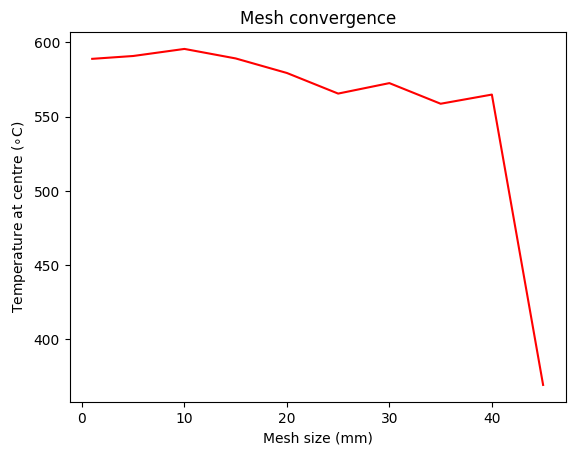

In [20]:
# mesh_name_format = "rectangle_{}.msh"

mesh_size_factors = np.array([1]+ np.arange(5,50,5).tolist())
meshFactorForAdaptiveSurface = 0.15
rep = np.array([50,25,0]).reshape(1,-1)
mesh_sizes = []
T_reps = []
numberOfEles = []
for mesh_size_factor in mesh_size_factors:
    print(mesh_size_factor)
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=mesh_size_factor,
                                    meshFactorForAdaptiveSurface=meshFactorForAdaptiveSurface,
                                    xSource=50,
                                    ySource=25,
                                    isMeshRectangle=True
                                )
    soln1 = FEM(nodecoords,ele_con,np.array([[50,25]]))
    h,K,G,F,boundary,theta = soln1.fit_ele(mode = "linear",verbose = False)
    mesh_sizes.append(h)

    distances = np.sum(np.square(nodecoords-rep),axis = 1)
    closest = np.argmin(distances)
    T_reps.append(theta[closest])
    numberOfEles.append(len(ele_con))

plt.plot(mesh_size_factors,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh size (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()
    

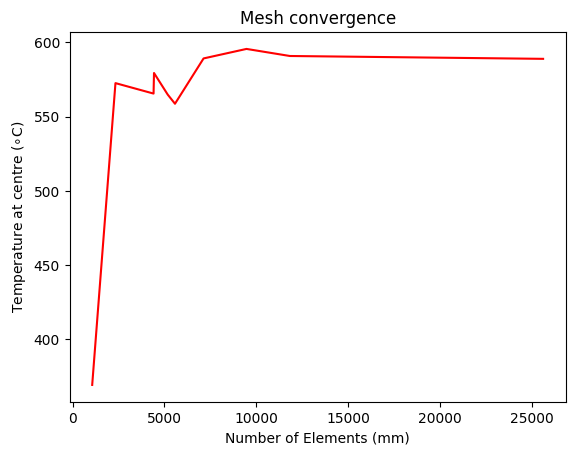

In [21]:
ele = np.argsort(numberOfEles)
plt.plot(np.array(numberOfEles)[ele],np.array(T_reps)[ele],'r')
plt.title('Mesh convergence')
plt.xlabel('Number of Elements (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

## Final solution

In [22]:
def picard(nodecoords,ele_con,theta_init,source,mode="non_linear"):
## the idea is you initialize a temperature profile and find corresponding multipliers for the non linear terms
    #non is number of nodes
    theta_old = theta_init

    e = 1e5
    tolerance = 1e-4
    iter = 0
    
    while(e>tolerance):
        iter +=1
        _,_,_,_,_,theta_new = FEM(nodecoords,ele_con,source).fit_ele(theta_prev_time = theta_init,theta_prev_pic = theta_old,mode = mode)
        e = np.linalg.norm(theta_new - theta_old) 
        
        theta_old = theta_new
        print(f"Error at {iter} iteration is {e:.2E}")
        # print(theta_init)
    plt.figure(figsize=(8,4))
    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten(),cmap='jet')
    plt.title(f"Source at {source[0,0],source[0,1]}")
    plt.colorbar()
    plt.show()

    return theta_new

Reading Mesh.msh
Number of nodes in the mesh: 13015
Number of triangles in the mesh: 25728



Reading Mesh.msh
Number of nodes in the mesh: 13015
Number of triangles in the mesh: 25728

Reading Mesh.msh
Number of nodes in the mesh: 13015
Number of triangles in the mesh: 25728

Time is 12.5 seconds
Error at 1 iteration is 5.24E+04
Error at 2 iteration is 6.34E+01
Error at 3 iteration is 3.43E-02
Error at 4 iteration is 1.14E-05


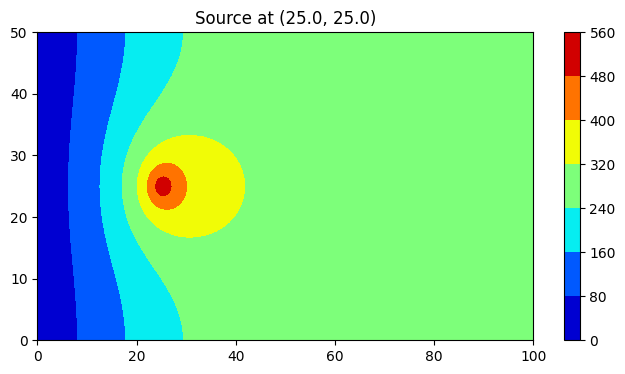

Reading Mesh.msh
Number of nodes in the mesh: 12958
Number of triangles in the mesh: 25614

Reading Mesh.msh
Number of nodes in the mesh: 12958
Number of triangles in the mesh: 25614

Time is 25 seconds
Error at 1 iteration is 4.42E+04
Error at 2 iteration is 5.26E+01
Error at 3 iteration is 2.52E-02
Error at 4 iteration is 6.43E-06


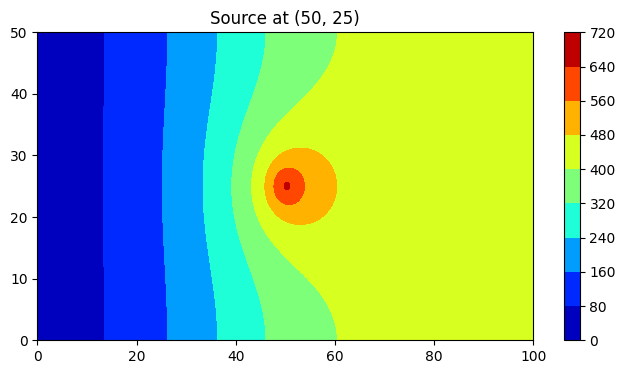

Reading Mesh.msh
Number of nodes in the mesh: 13093
Number of triangles in the mesh: 25884

Reading Mesh.msh
Number of nodes in the mesh: 13093
Number of triangles in the mesh: 25884

Time is 37.5 seconds
Error at 1 iteration is 4.57E+04
Error at 2 iteration is 3.65E+01
Error at 3 iteration is 1.44E-02
Error at 4 iteration is 3.67E-06


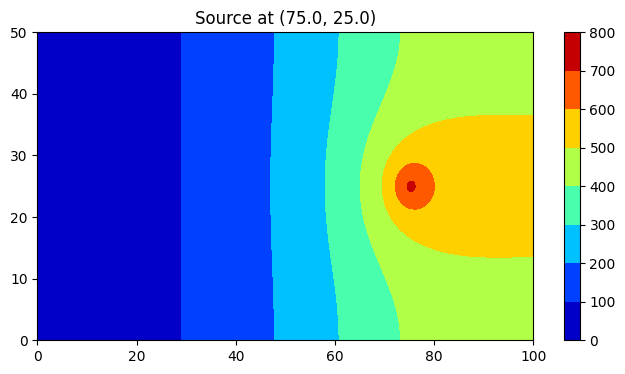

Reading Mesh.msh
Number of nodes in the mesh: 9493
Number of triangles in the mesh: 18610



In [29]:
T_l = 273+500
vo = 2 #mm/s
t_final = 10
times = [12.5,25,37.5]
convergedMeshFactorForEntireSurface = 1
x_source = 0
nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=convergedMeshFactorForEntireSurface,
                                    meshFactorForAdaptiveSurface=meshFactorForAdaptiveSurface,
                                    xSource=x_source +times[0]*vo,
                                    ySource=25,
                                    isMeshRectangle=True)

theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
for i,t in enumerate(times):
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=convergedMeshFactorForEntireSurface,
                                    meshFactorForAdaptiveSurface=meshFactorForAdaptiveSurface,
                                    xSource=x_source+vo*t,
                                    ySource=25,
                                    isMeshRectangle=True
                                )
    print(f"Time is {t} seconds")
    theta_final = picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source+vo*t,25]]))
    nodecoords,_ = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=convergedMeshFactorForEntireSurface,
                                    meshFactorForAdaptiveSurface=meshFactorForAdaptiveSurface,
                                    xSource=x_source+vo*(times[i+1] if i+1 < len(times) else 0),
                                    ySource=25,
                                    isMeshRectangle=True
                                )
    theta_prev = np.zeros((nodecoords.shape[0],1))+T_l

0.7
Reading Mesh.msh
Number of nodes in the mesh: 3179
Number of triangles in the mesh: 6136

0.725
Reading Mesh.msh
Number of nodes in the mesh: 2918
Number of triangles in the mesh: 5624

0.75
Reading Mesh.msh
Number of nodes in the mesh: 2792
Number of triangles in the mesh: 5380

0.775
Reading Mesh.msh
Number of nodes in the mesh: 2595
Number of triangles in the mesh: 4990

0.8
Reading Mesh.msh
Number of nodes in the mesh: 2474
Number of triangles in the mesh: 4756

0.8250000000000001
Reading Mesh.msh
Number of nodes in the mesh: 2321
Number of triangles in the mesh: 4454

0.8500000000000001
Reading Mesh.msh
Number of nodes in the mesh: 2183
Number of triangles in the mesh: 4182

0.8750000000000001
Reading Mesh.msh
Number of nodes in the mesh: 2078
Number of triangles in the mesh: 3978

0.9000000000000001
Reading Mesh.msh
Number of nodes in the mesh: 2016
Number of triangles in the mesh: 3858

0.9250000000000002
Reading Mesh.msh
Number of nodes in the mesh: 1919
Number of triangles

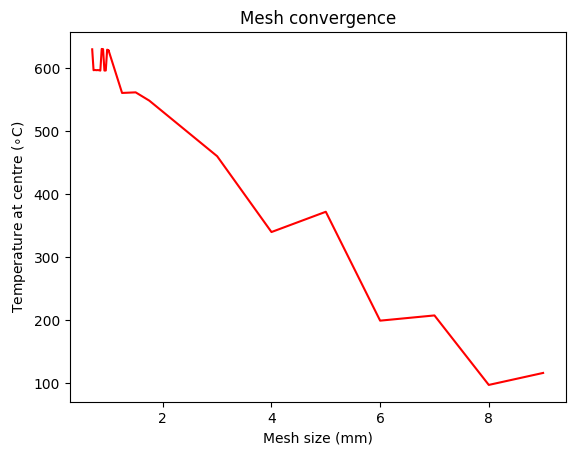

In [60]:
# mesh_name_format = "rectangle_{}.msh"

mesh_size_factors = np.array(np.arange(0.7,1,0.025).tolist()+ np.arange(1,2,0.25).tolist() + np.arange(3,10,1).tolist())
rep = np.array([50,25,0]).reshape(1,-1)
mesh_sizes = []
T_reps = []
numberOfEles = []
for mesh_size_factor in mesh_size_factors:
    print(mesh_size_factor)
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=mesh_size_factor,
                                )
    soln1 = FEM(nodecoords,ele_con,np.array([[50,25]]))
    h,K,G,F,boundary,theta = soln1.fit_ele(mode = "linear",verbose = False)
    mesh_sizes.append(h)

    distances = np.sum(np.square(nodecoords-rep),axis = 1)
    closest = np.argmin(distances)
    T_reps.append(theta[closest])
    numberOfEles.append(len(ele_con))

plt.plot(mesh_size_factors,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh size (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()
    

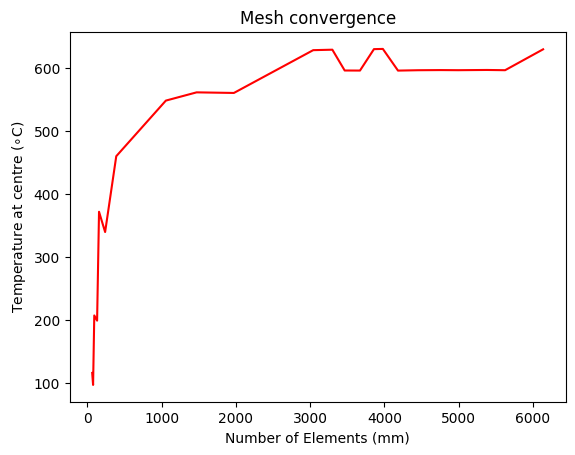

In [61]:
ele = np.argsort(numberOfEles)
plt.plot(np.array(numberOfEles)[ele],np.array(T_reps)[ele],'r')
plt.title('Mesh convergence')
plt.xlabel('Number of Elements (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 0 seconds
Error at 1 iteration is 2.43E+04
Error at 2 iteration is 3.20E+03
Error at 3 iteration is 4.96E+02
Error at 4 iteration is 1.31E+02
Error at 5 iteration is 1.81E+01
Error at 6 iteration is 4.89E+00
Error at 7 iteration is 6.55E-01
Error at 8 iteration is 1.80E-01
Error at 9 iteration is 2.40E-02
Error at 10 iteration is 6.33E-03
Error at 11 iteration is 8.84E-04
Error at 12 iteration is 2.15E-04
Error at 13 iteration is 3.23E-05


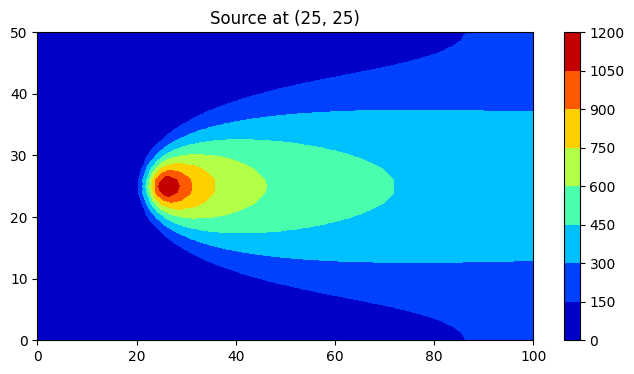

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 2 seconds
Error at 1 iteration is 2.96E+03
Error at 2 iteration is 1.56E+03
Error at 3 iteration is 2.57E+02
Error at 4 iteration is 8.29E+01
Error at 5 iteration is 1.16E+01
Error at 6 iteration is 3.56E+00
Error at 7 iteration is 5.10E-01
Error at 8 iteration is 1.37E-01
Error at 9 iteration is 2.16E-02
Error at 10 iteration is 4.83E-03
Error at 11 iteration is 8.69E-04
Error at 12 iteration is 1.62E-04
Error at 13 iteration is 3.31E-05


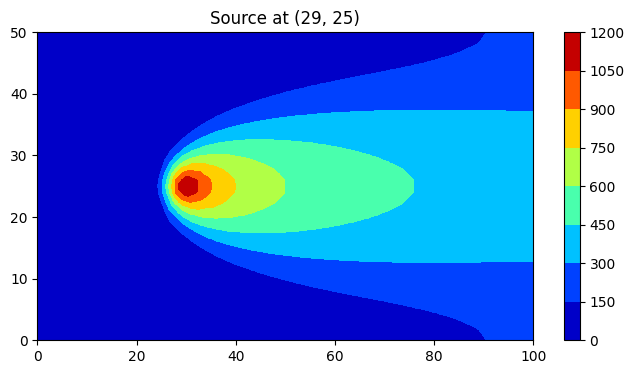

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 4 seconds
Error at 1 iteration is 2.98E+03
Error at 2 iteration is 1.53E+03
Error at 3 iteration is 2.53E+02
Error at 4 iteration is 8.10E+01
Error at 5 iteration is 1.14E+01
Error at 6 iteration is 3.48E+00
Error at 7 iteration is 4.98E-01
Error at 8 iteration is 1.34E-01
Error at 9 iteration is 2.11E-02
Error at 10 iteration is 4.74E-03
Error at 11 iteration is 8.47E-04
Error at 12 iteration is 1.60E-04
Error at 13 iteration is 3.23E-05


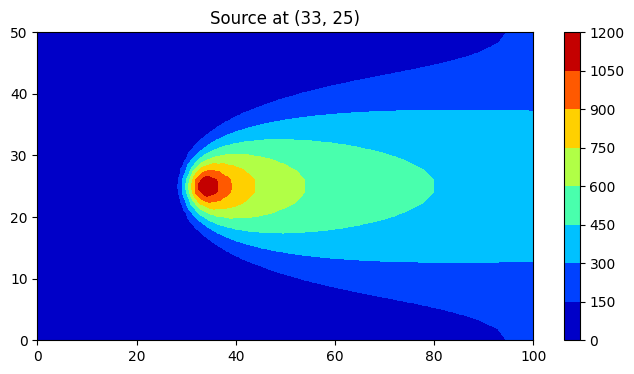

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 6 seconds
Error at 1 iteration is 2.95E+03
Error at 2 iteration is 1.51E+03
Error at 3 iteration is 2.50E+02
Error at 4 iteration is 7.90E+01
Error at 5 iteration is 1.11E+01
Error at 6 iteration is 3.37E+00
Error at 7 iteration is 4.80E-01
Error at 8 iteration is 1.29E-01
Error at 9 iteration is 2.01E-02
Error at 10 iteration is 4.55E-03
Error at 11 iteration is 7.96E-04
Error at 12 iteration is 1.53E-04
Error at 13 iteration is 3.00E-05


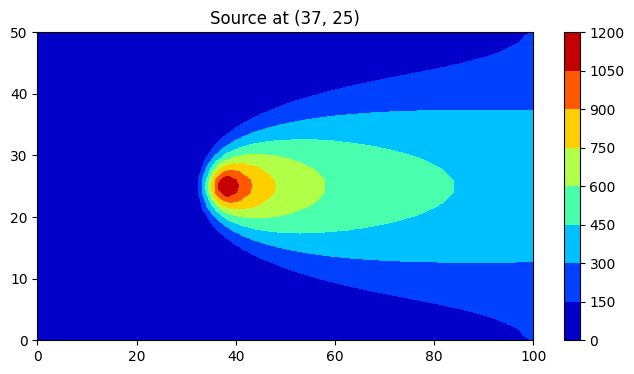

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 8 seconds
Error at 1 iteration is 2.90E+03
Error at 2 iteration is 1.48E+03
Error at 3 iteration is 2.47E+02
Error at 4 iteration is 7.67E+01
Error at 5 iteration is 1.08E+01
Error at 6 iteration is 3.26E+00
Error at 7 iteration is 4.65E-01
Error at 8 iteration is 1.24E-01
Error at 9 iteration is 1.91E-02
Error at 10 iteration is 4.36E-03
Error at 11 iteration is 7.46E-04
Error at 12 iteration is 1.45E-04
Error at 13 iteration is 2.76E-05


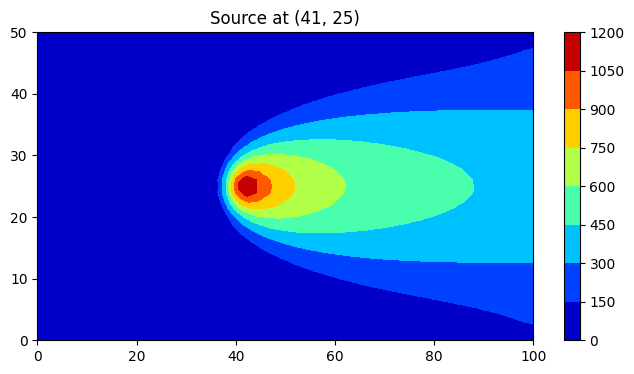

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 10 seconds
Error at 1 iteration is 2.89E+03
Error at 2 iteration is 1.45E+03
Error at 3 iteration is 2.46E+02
Error at 4 iteration is 7.45E+01
Error at 5 iteration is 1.07E+01
Error at 6 iteration is 3.17E+00
Error at 7 iteration is 4.55E-01
Error at 8 iteration is 1.21E-01
Error at 9 iteration is 1.87E-02
Error at 10 iteration is 4.25E-03
Error at 11 iteration is 7.25E-04
Error at 12 iteration is 1.42E-04
Error at 13 iteration is 2.68E-05


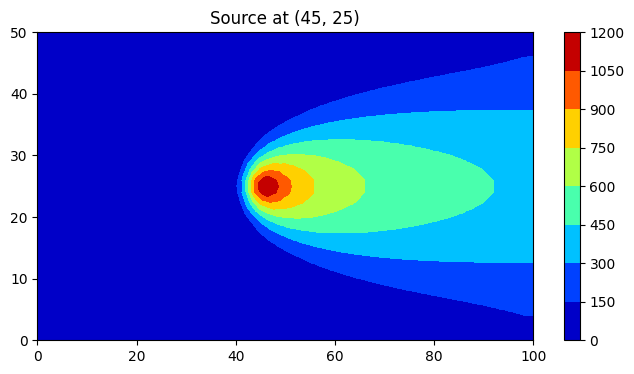

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 12 seconds
Error at 1 iteration is 2.84E+03
Error at 2 iteration is 1.43E+03
Error at 3 iteration is 2.42E+02
Error at 4 iteration is 7.25E+01
Error at 5 iteration is 1.04E+01
Error at 6 iteration is 3.08E+00
Error at 7 iteration is 4.45E-01
Error at 8 iteration is 1.18E-01
Error at 9 iteration is 1.83E-02
Error at 10 iteration is 4.21E-03
Error at 11 iteration is 7.19E-04
Error at 12 iteration is 1.43E-04
Error at 13 iteration is 2.69E-05


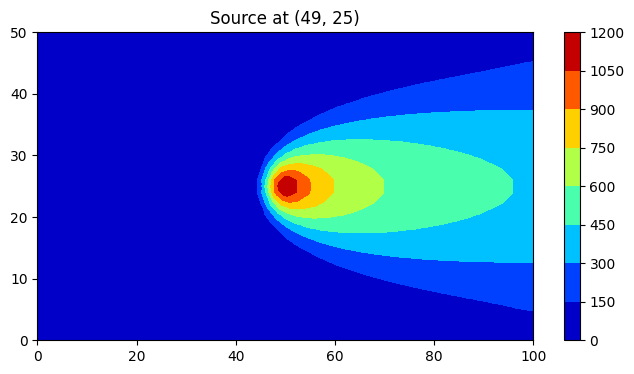

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 14 seconds
Error at 1 iteration is 2.88E+03
Error at 2 iteration is 1.40E+03
Error at 3 iteration is 2.40E+02
Error at 4 iteration is 7.02E+01
Error at 5 iteration is 1.03E+01
Error at 6 iteration is 2.99E+00
Error at 7 iteration is 4.35E-01
Error at 8 iteration is 1.15E-01
Error at 9 iteration is 1.78E-02
Error at 10 iteration is 4.15E-03
Error at 11 iteration is 6.99E-04
Error at 12 iteration is 1.43E-04
Error at 13 iteration is 2.63E-05


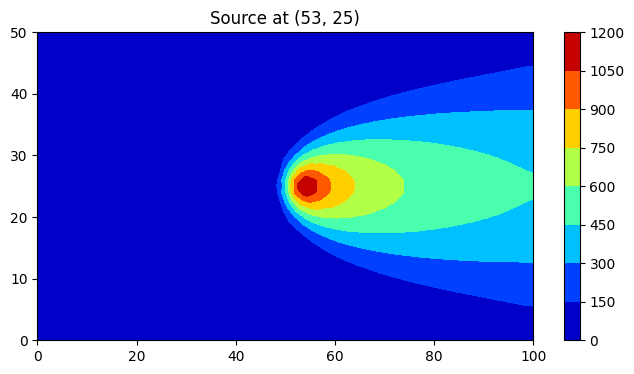

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 16 seconds
Error at 1 iteration is 2.90E+03
Error at 2 iteration is 1.36E+03
Error at 3 iteration is 2.36E+02
Error at 4 iteration is 6.73E+01
Error at 5 iteration is 9.94E+00
Error at 6 iteration is 2.85E+00
Error at 7 iteration is 4.16E-01
Error at 8 iteration is 1.10E-01
Error at 9 iteration is 1.68E-02
Error at 10 iteration is 3.92E-03
Error at 11 iteration is 6.51E-04
Error at 12 iteration is 1.34E-04
Error at 13 iteration is 2.42E-05


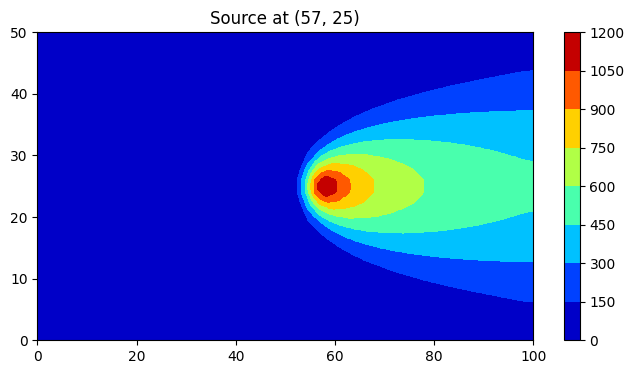

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 18 seconds
Error at 1 iteration is 2.85E+03
Error at 2 iteration is 1.33E+03
Error at 3 iteration is 2.32E+02
Error at 4 iteration is 6.44E+01
Error at 5 iteration is 9.63E+00
Error at 6 iteration is 2.71E+00
Error at 7 iteration is 3.97E-01
Error at 8 iteration is 1.04E-01
Error at 9 iteration is 1.57E-02
Error at 10 iteration is 3.70E-03
Error at 11 iteration is 5.98E-04
Error at 12 iteration is 1.26E-04
Error at 13 iteration is 2.19E-05


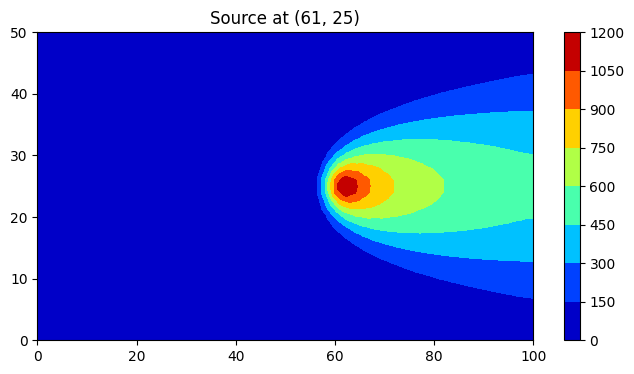

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 20 seconds
Error at 1 iteration is 2.85E+03
Error at 2 iteration is 1.29E+03
Error at 3 iteration is 2.29E+02
Error at 4 iteration is 6.14E+01
Error at 5 iteration is 9.38E+00
Error at 6 iteration is 2.60E+00
Error at 7 iteration is 3.87E-01
Error at 8 iteration is 1.00E-01
Error at 9 iteration is 1.54E-02
Error at 10 iteration is 3.61E-03
Error at 11 iteration is 5.91E-04
Error at 12 iteration is 1.24E-04
Error at 13 iteration is 2.19E-05


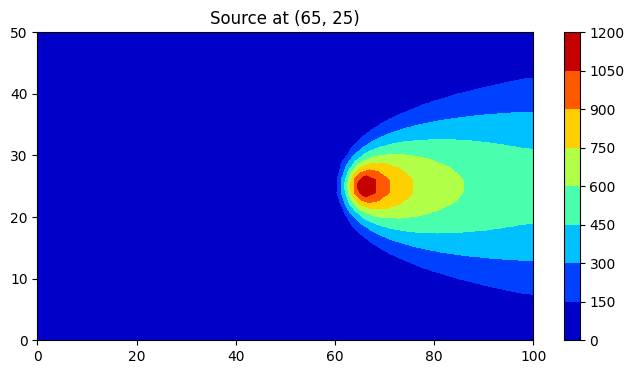

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 22 seconds
Error at 1 iteration is 2.81E+03
Error at 2 iteration is 1.24E+03
Error at 3 iteration is 2.27E+02
Error at 4 iteration is 5.84E+01
Error at 5 iteration is 9.18E+00
Error at 6 iteration is 2.50E+00
Error at 7 iteration is 3.80E-01
Error at 8 iteration is 9.83E-02
Error at 9 iteration is 1.54E-02
Error at 10 iteration is 3.60E-03
Error at 11 iteration is 6.09E-04
Error at 12 iteration is 1.25E-04
Error at 13 iteration is 2.32E-05


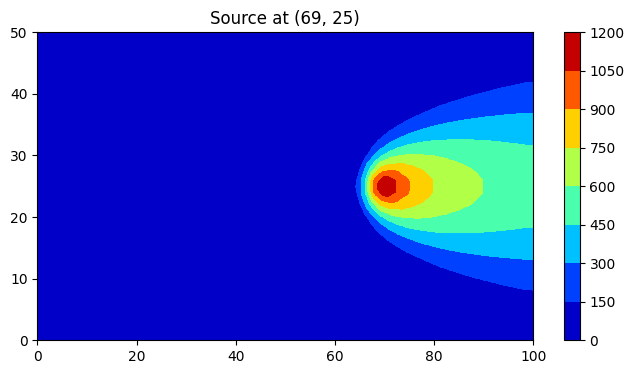

Reading Mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 24 seconds
Error at 1 iteration is 2.79E+03
Error at 2 iteration is 1.20E+03
Error at 3 iteration is 2.22E+02
Error at 4 iteration is 5.50E+01
Error at 5 iteration is 8.81E+00
Error at 6 iteration is 2.35E+00
Error at 7 iteration is 3.61E-01
Error at 8 iteration is 9.28E-02
Error at 9 iteration is 1.46E-02
Error at 10 iteration is 3.43E-03
Error at 11 iteration is 5.76E-04
Error at 12 iteration is 1.21E-04
Error at 13 iteration is 2.22E-05


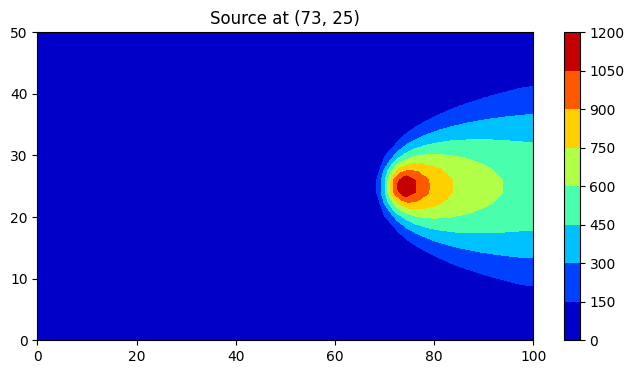

In [32]:
nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                meshFactorForEntireSurface=1
                                )
T_l = 273+500
vo = 2 #mm/s
t_final = 25
times = np.arange(0,t_final,2)
theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
x_source = 25
for t in times:
    nodecoords,ele_con = createMesh(geo_file='rectange.geo',
                                    meshFactorForEntireSurface=1
                                )
    print(f"Time is {t} seconds")
    theta_final = picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source+vo*t,25]]),mode="phase_change")
    theta_prev = theta_final